In [1]:
# Import Libraries and Load Cleaned Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load cleaned data
df = pd.read_csv("../data/pcos_cleaned.csv")

# Load feature config
with open("../data/feature_config.json", 'r') as f:
    config = json.load(f)

TARGET = config['target']
STAGE1_FEATURES = config['stage1_features']
STAGE2_FEATURES = config['stage2_features']
ALL_FEATURES = config['all_features']

# Color palette
COLORS = {
    'pink': '#fb6f92',
    'green': '#38b000',
    'lilac': '#e0aaff',
    'amber': '#ff9e00',
    'sky': '#90e0ef',
    'peach': '#ff6d00',
}

print("Libraries imported successfully!")
print(f"Dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Target: {TARGET}")
print(f"Features: {len(ALL_FEATURES)} total")

Libraries imported successfully!
Dataset: 541 rows × 40 columns
Target: PCOS (Y/N)
Features: 39 total


In [2]:
# Prepare Features and Target Variables
# Separate features (X) and target (y)
X = df[ALL_FEATURES]
y = df[TARGET]

print(f"Features (X): {X.shape}")
print(f"Target (y):   {y.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(X.columns, 1):
    stage = "S1" if col in STAGE1_FEATURES else "S2" if col in STAGE2_FEATURES else "Other"
    print(f"   {i:2}. [{stage}] {col}")

Features (X): (541, 39)
Target (y):   (541,)

Feature columns:
    1. [S1] Age (yrs)
    2. [S1] Weight (Kg)
    3. [S1] Height(Cm)
    4. [S1] BMI
    5. [S1] Cycle(R/I)
    6. [S1] Cycle length(days)
    7. [S1] Weight gain(Y/N)
    8. [S1] hair growth(Y/N)
    9. [S1] Skin darkening (Y/N)
   10. [S1] Hair loss(Y/N)
   11. [S1] Pimples(Y/N)
   12. [S1] Fast food (Y/N)
   13. [S1] Reg.Exercise(Y/N)
   14. [S1] Marraige Status (Yrs)
   15. [S1] Pregnant(Y/N)
   16. [S1] No. of aborptions
   17. [S2] FSH(mIU/mL)
   18. [S2] LH(mIU/mL)
   19. [S2] FSH/LH
   20. [S2] AMH(ng/mL)
   21. [S2] TSH (mIU/L)
   22. [S2] Follicle No. (L)
   23. [S2] Follicle No. (R)
   24. [S2] Avg. F size (L) (mm)
   25. [S2] Avg. F size (R) (mm)
   26. [S2] Endometrium (mm)
   27. [S2] PRL(ng/mL)
   28. [S2] Vit D3 (ng/mL)
   29. [S2] PRG(ng/mL)
   30. [S2] Hb(g/dl)
   31. [S2] RBS(mg/dl)
   32. [Other] Blood Group
   33. [Other] Pulse rate(bpm)
   34. [Other] RR (breaths/min)
   35. [Other] Hip(inch)
   36. [O

In [3]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility (same split every time)
    stratify=y               # Maintain class proportions
)

print("Train-Test Split (Stratified):\n")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass Distribution:")
print(f"Train - No PCOS: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"Train - PCOS:    {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")
print(f"Test  - No PCOS: {(y_test==0).sum()} ({(y_test==0).mean()*100:.1f}%)")
print(f"Test  - PCOS:    {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")

Train-Test Split (Stratified):

Training set: 432 samples (79.9%)
Testing set:  109 samples (20.1%)

Class Distribution:
Train - No PCOS: 291 (67.4%)
Train - PCOS:    141 (32.6%)
Test  - No PCOS: 73 (67.0%)
Test  - PCOS:    36 (33.0%)


In [4]:
# Feature Scaling with StandardScaler
scaler = StandardScaler()

# Fit on training data ONLY, then transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Features scaled using StandardScaler\n")
print("Before scaling (first feature - Age):")
print(f"Mean: {X_train['Age (yrs)'].mean():.2f}, Std: {X_train['Age (yrs)'].std():.2f}")
print(f"\nAfter scaling:")
print(f"Mean: {X_train_scaled['Age (yrs)'].mean():.2f}, Std: {X_train_scaled['Age (yrs)'].std():.2f}")

Features scaled using StandardScaler

Before scaling (first feature - Age):
Mean: 31.42, Std: 5.43

After scaling:
Mean: -0.00, Std: 1.00


In [5]:
# Apply SMOTE to Training Data
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:")
print(f"No PCOS: {(y_train==0).sum()}")
print(f"PCOS:    {(y_train==1).sum()}")

print(f"\nAfter SMOTE:")
print(f"No PCOS: {(y_train_resampled==0).sum()}")
print(f"PCOS:    {(y_train_resampled==1).sum()}")

print(f"\nTraining data now balanced! ({len(X_train_resampled)} total samples)")

Before SMOTE:
No PCOS: 291
PCOS:    141

After SMOTE:
No PCOS: 291
PCOS:    291

Training data now balanced! (582 total samples)


In [6]:
# Define the Three Models to Compare
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,      # More iterations for convergence
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',       # Radial basis function - handles non-linear data
        probability=True,   # Enable probability predictions (needed for AUC)
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,   # Number of trees
        max_depth=10,       # Prevent overfitting
        random_state=42
    )
}

print("Models Defined:")
for name, model in models.items():
    print(f"{name}")

Models Defined:
Logistic Regression
SVM
Random Forest


In [7]:
# Stratified K-Fold Cross-Validation
# Setup stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
cv_results = {}

print("Running 5-Fold Stratified Cross-Validation...\n")
print("="*70)

for name, model in models.items():
    print(f"\n{name}:")
    
    # Multiple scoring metrics
    accuracy = cross_val_score(model, X_train_resampled, y_train_resampled, 
                               cv=cv, scoring='accuracy')
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, 
                         cv=cv, scoring='f1')
    roc_auc = cross_val_score(model, X_train_resampled, y_train_resampled, 
                              cv=cv, scoring='roc_auc')
    
    cv_results[name] = {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    print(f"   Accuracy: {accuracy.mean():.4f} (+/- {accuracy.std():.4f})")
    print(f"   F1 Score: {f1.mean():.4f} (+/- {f1.std():.4f})")
    print(f"   ROC-AUC:  {roc_auc.mean():.4f} (+/- {roc_auc.std():.4f})")

print("\n" + "="*70)
print("Cross-Validation Complete!")

Running 5-Fold Stratified Cross-Validation...


Logistic Regression:
   Accuracy: 0.8952 (+/- 0.0154)
   F1 Score: 0.8966 (+/- 0.0142)
   ROC-AUC:  0.9633 (+/- 0.0185)

SVM:
   Accuracy: 0.9159 (+/- 0.0301)
   F1 Score: 0.9162 (+/- 0.0286)
   ROC-AUC:  0.9741 (+/- 0.0187)

Random Forest:
   Accuracy: 0.9262 (+/- 0.0278)
   F1 Score: 0.9259 (+/- 0.0266)
   ROC-AUC:  0.9799 (+/- 0.0112)

Cross-Validation Complete!


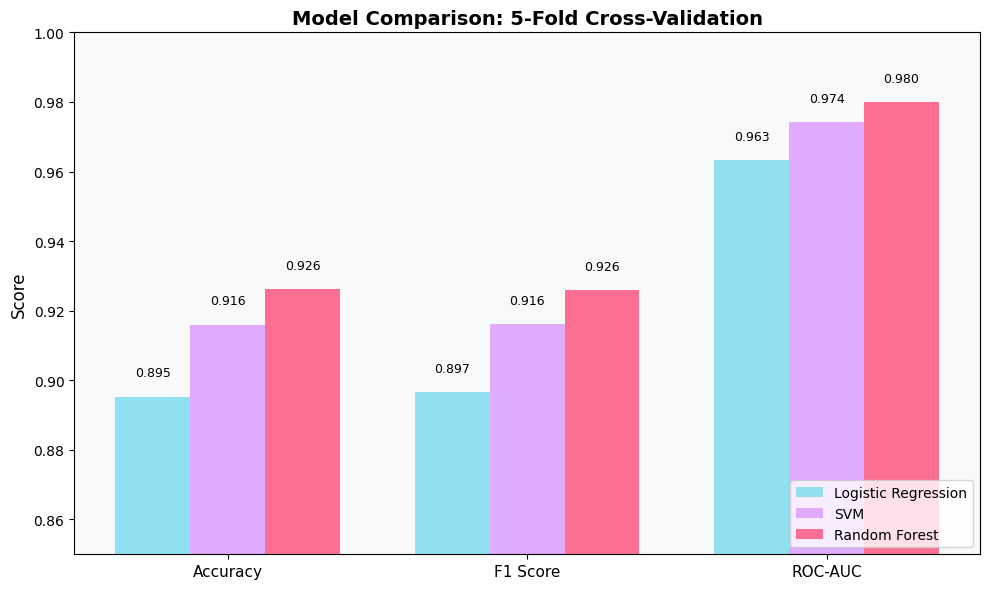


Best Model: Random Forest
→ Selected based on highest F1 Score


In [8]:
# Visualize Cross-Validation Results
metrics = ['Accuracy', 'F1 Score', 'ROC-AUC']
model_names = list(cv_results.keys())

# Prepare data
data = {
    'Logistic Regression': [cv_results['Logistic Regression']['accuracy'].mean(),
                            cv_results['Logistic Regression']['f1'].mean(),
                            cv_results['Logistic Regression']['roc_auc'].mean()],
    'SVM': [cv_results['SVM']['accuracy'].mean(),
            cv_results['SVM']['f1'].mean(),
            cv_results['SVM']['roc_auc'].mean()],
    'Random Forest': [cv_results['Random Forest']['accuracy'].mean(),
                      cv_results['Random Forest']['f1'].mean(),
                      cv_results['Random Forest']['roc_auc'].mean()]
}

# Create grouped bar chart
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, data['Logistic Regression'], width, label='Logistic Regression', color=COLORS['sky'])
bars2 = ax.bar(x, data['SVM'], width, label='SVM', color=COLORS['lilac'])
bars3 = ax.bar(x + width, data['Random Forest'], width, label='Random Forest', color=COLORS['pink'])

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison: 5-Fold Cross-Validation', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right')
ax.set_ylim(0.85, 1.0)
ax.set_facecolor('#f8f9fa')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = max(cv_results.keys(), 
                      key=lambda k: cv_results[k]['f1'].mean())
print(f"\nBest Model: {best_model_name}")
print(f"→ Selected based on highest F1 Score")

In [9]:
# Train Best Model (Random Forest) on Full Training Data

# Select the best model
best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Train on full resampled training data
best_model.fit(X_train_resampled, y_train_resampled)

print("Random Forest trained on full training data!")
print(f"   Training samples: {len(X_train_resampled)}")
print(f"   Features: {X_train_resampled.shape[1]}")

Random Forest trained on full training data!
   Training samples: 582
   Features: 39


In [10]:
# Evaluate on Test Set (Unseen Data)
# Make predictions on test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # Probability of PCOS

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print("TEST SET EVALUATION (Unseen Data)")
print("=" * 60)
print(f"\n   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1 Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"   ROC-AUC:   {test_roc_auc:.4f} ({test_roc_auc*100:.2f}%)")
print("\n" + "=" * 60)

# Check if we meet target
if test_accuracy >= 0.85:
    print("TARGET MET: Accuracy >= 85%!")
else:
    print("Below target - may need hyperparameter tuning")

TEST SET EVALUATION (Unseen Data)

   Accuracy:  0.9266 (92.66%)
   Precision: 0.9375 (93.75%)
   Recall:    0.8333 (83.33%)
   F1 Score:  0.8824 (88.24%)
   ROC-AUC:   0.9378 (93.78%)

TARGET MET: Accuracy >= 85%!


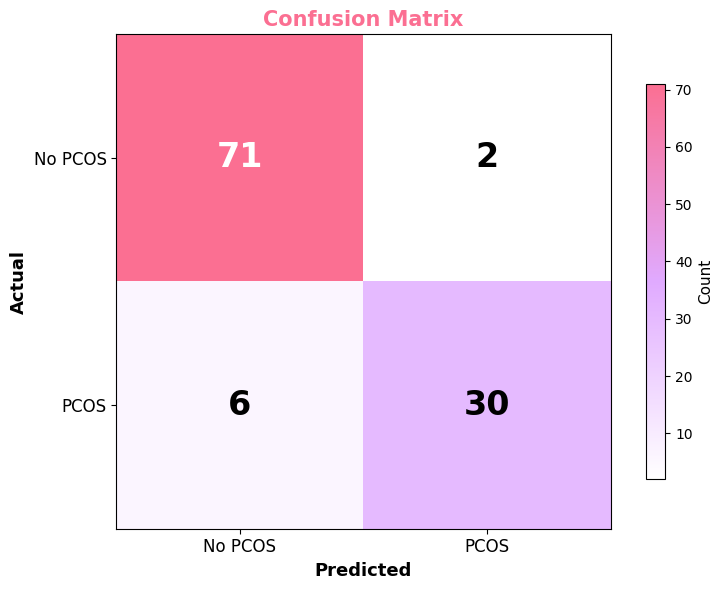


Confusion Matrix Breakdown:
   True Negatives (TN):  71 - Correctly identified No PCOS
   True Positives (TP):  30 - Correctly identified PCOS
   False Positives (FP): 2 - Incorrectly predicted PCOS
   False Negatives (FN): 6 - Missed PCOS cases


In [16]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

# Create custom colormap using your colors (lilac to pink gradient)
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('custom', 
    ['#ffffff', '#e0aaff', '#fb6f92'])  # White → Lilac → Pink

fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap with custom colors
im = ax.imshow(cm, cmap=custom_cmap)

# Add text annotations
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', 
                fontsize=24, fontweight='bold', color=text_color)

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No PCOS', 'PCOS'], fontsize=12)
ax.set_yticklabels(['No PCOS', 'PCOS'], fontsize=12)
ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax.set_ylabel('Actual', fontsize=13, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=15, fontweight='bold', color='#fb6f92')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Count', fontsize=11)

plt.tight_layout()
plt.show()

# Extract values
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn} - Correctly identified No PCOS")
print(f"   True Positives (TP):  {tp} - Correctly identified PCOS")
print(f"   False Positives (FP): {fp} - Incorrectly predicted PCOS")
print(f"   False Negatives (FN): {fn} - Missed PCOS cases")

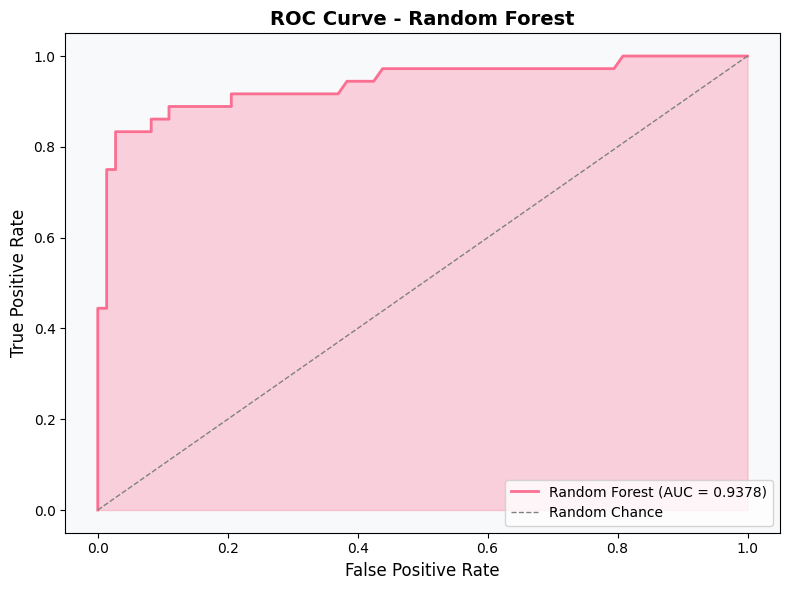


ROC-AUC Score: 0.9378
   Excellent discriminative ability!


In [12]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve
ax.plot(fpr, tpr, color=COLORS['pink'], lw=2, 
        label=f'Random Forest (AUC = {test_roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Chance')

ax.fill_between(fpr, tpr, alpha=0.3, color=COLORS['pink'])

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {test_roc_auc:.4f}")
if test_roc_auc >= 0.9:
    print("   Excellent discriminative ability!")

In [17]:
# Error Analysis - Understanding Failed Predictions
# Get original test data (not scaled) for readability
X_test_original = X_test.copy()
X_test_original['PCOS_Actual'] = y_test.values
X_test_original['PCOS_Predicted'] = y_pred
X_test_original['Prediction_Prob'] = y_pred_proba

# False Negatives: Actual=1, Predicted=0 (MISSED PCOS)
fn_cases = X_test_original[(X_test_original['PCOS_Actual'] == 1) & 
                           (X_test_original['PCOS_Predicted'] == 0)]

# False Positives: Actual=0, Predicted=1 (FALSE ALARM)
fp_cases = X_test_original[(X_test_original['PCOS_Actual'] == 0) & 
                           (X_test_original['PCOS_Predicted'] == 1)]

print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

print(f"\nFALSE NEGATIVES (Missed PCOS): {len(fn_cases)} cases")
print("-" * 40)
if len(fn_cases) > 0:
    # Show key features of missed cases
    key_features = ['Follicle No. (L)', 'Follicle No. (R)', 'BMI', 'AMH(ng/mL)', 
                    'Skin darkening (Y/N)', 'hair growth(Y/N)', 'Prediction_Prob']
    print(fn_cases[key_features].to_string())
    
    print(f"\nPattern: These PCOS patients had prediction probabilities: ")
    print(f"   {fn_cases['Prediction_Prob'].values}")
    print(f"   (Close to 0.5 = borderline cases)")

print(f"\nFALSE POSITIVES (False Alarms): {len(fp_cases)} cases")
print("-" * 40)
if len(fp_cases) > 0:
    print(fp_cases[key_features].to_string())

ERROR ANALYSIS

FALSE NEGATIVES (Missed PCOS): 6 cases
----------------------------------------
     Follicle No. (L)  Follicle No. (R)        BMI  AMH(ng/mL)  Skin darkening (Y/N)  hair growth(Y/N)  Prediction_Prob
444                 1                 1  23.100000        16.9                     0                 0         0.072385
227                 1                 3  28.228386         0.2                     1                 1         0.180000
276                 6                 5  28.814526         1.8                     0                 0         0.390579
533                 8                10  20.500000        19.6                     0                 0         0.320000
132                 3                 3  25.299376         8.8                     1                 1         0.410000
455                 6                 7  23.100000         7.7                     0                 0         0.190000

Pattern: These PCOS patients had prediction probabilities: 
   

In [18]:
# Statistical Comparison of Errors
# Correctly classified PCOS cases
tp_cases = X_test_original[(X_test_original['PCOS_Actual'] == 1) & 
                           (X_test_original['PCOS_Predicted'] == 1)]

compare_features = ['Follicle No. (L)', 'Follicle No. (R)', 'BMI', 
                    'AMH(ng/mL)', 'LH(mIU/mL)', 'Cycle(R/I)']

print("Average Values Comparison (PCOS patients only):\n")
print(f"{'Feature':<20} {'Correctly ID':<15} {'Missed (FN)':<15} {'Difference'}")
print("-" * 60)

for feat in compare_features:
    correct_avg = tp_cases[feat].mean()
    missed_avg = fn_cases[feat].mean() if len(fn_cases) > 0 else 0
    diff = correct_avg - missed_avg
    print(f"{feat:<20} {correct_avg:<15.2f} {missed_avg:<15.2f} {diff:+.2f}")

print("\nInsight: Missed cases may have less pronounced symptoms/markers")

Average Values Comparison (PCOS patients only):

Feature              Correctly ID    Missed (FN)     Difference
------------------------------------------------------------
Follicle No. (L)     10.83           4.17            +6.67
Follicle No. (R)     12.80           4.83            +7.97
BMI                  25.43           24.84           +0.59
AMH(ng/mL)           5.69            9.17            -3.48
LH(mIU/mL)           2.54            339.81          -337.27
Cycle(R/I)           3.20            2.67            +0.53

Insight: Missed cases may have less pronounced symptoms/markers


SHAP values extracted for PCOS class!
   Shape: (109, 39)

Global Feature Importance (SHAP):


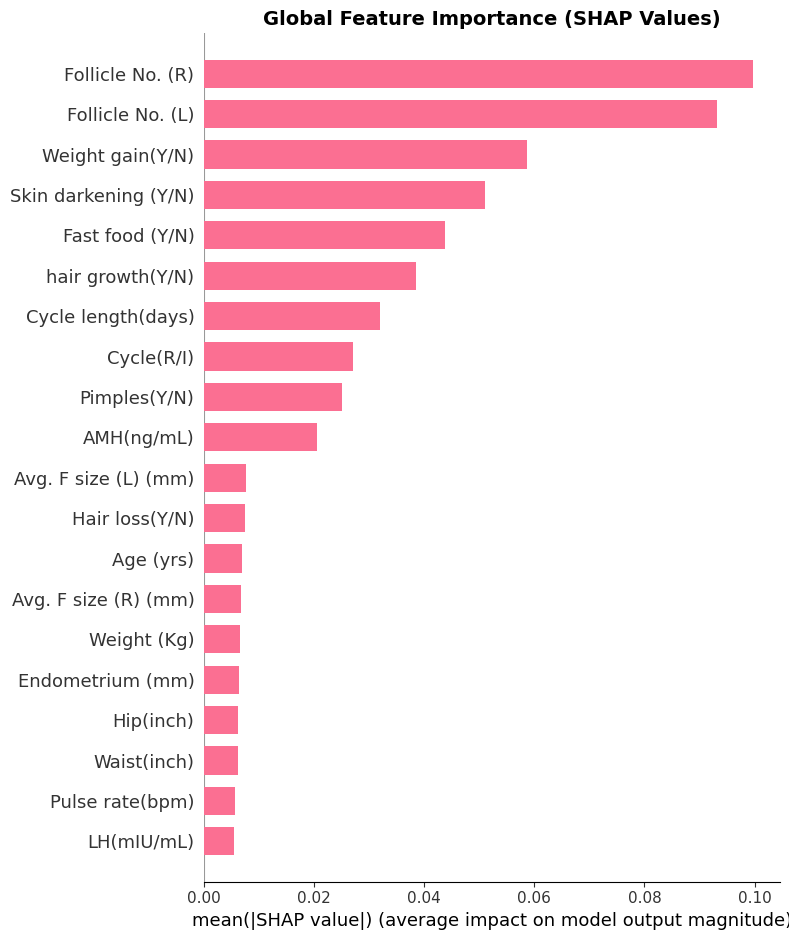

In [25]:
# # SHAP Global Feature Importance
import shap

# Create explainer and calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Extract SHAP values for PCOS class (class index 1)
shap_values_pcos = shap_values[:, :, 1]

print("SHAP values extracted for PCOS class!")
print(f"   Shape: {shap_values_pcos.shape}")  # Should be (109, 39)

# Global Feature Importance (bar plot)
print("\nGlobal Feature Importance (SHAP):")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_pcos, X_test_scaled.values, 
                  feature_names=X_test_scaled.columns.tolist(),
                  plot_type="bar", show=False, color=COLORS['pink'])
plt.title("Global Feature Importance (SHAP Values)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

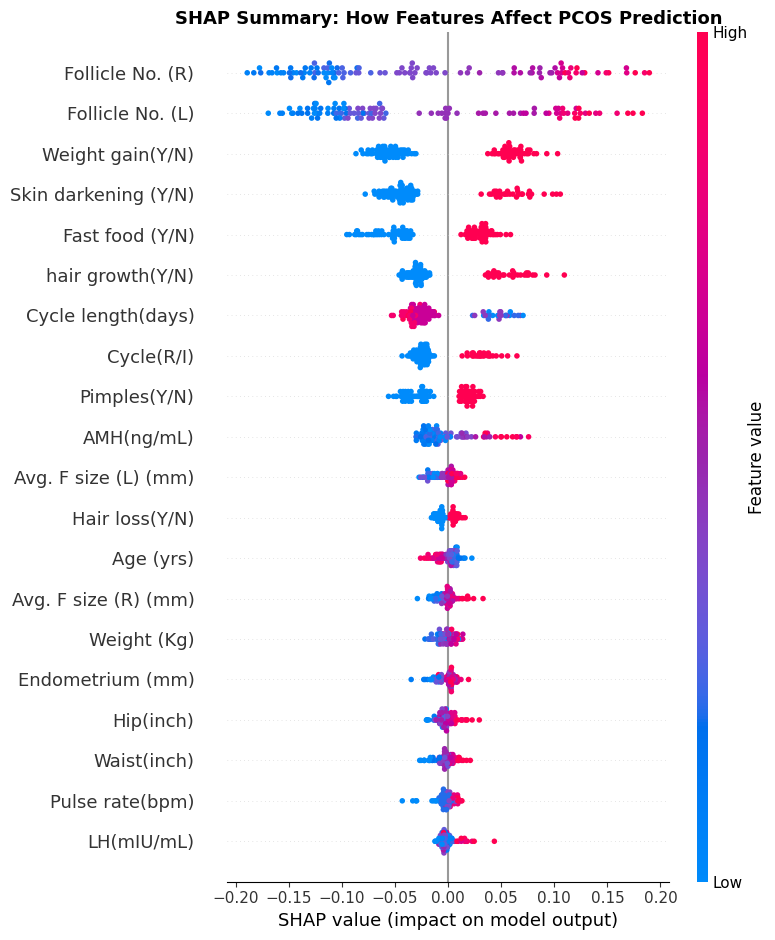


How to read:
   • Dots on RIGHT → Feature INCREASES PCOS risk
   • Dots on LEFT → Feature DECREASES PCOS risk
   • Red dots = HIGH feature value, Blue = LOW value


In [26]:
# SHAP Summary (Beeswarm) Plot
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values_pcos, X_test_scaled.values,
                  feature_names=X_test_scaled.columns.tolist(),
                  show=False)
plt.title("SHAP Summary: How Features Affect PCOS Prediction", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHow to read:")
print("   • Dots on RIGHT → Feature INCREASES PCOS risk")
print("   • Dots on LEFT → Feature DECREASES PCOS risk")
print("   • Red dots = HIGH feature value, Blue = LOW value")

Patient Index: 444
   Actual: PCOS
   Predicted: No PCOS
   Probability: 7.24%


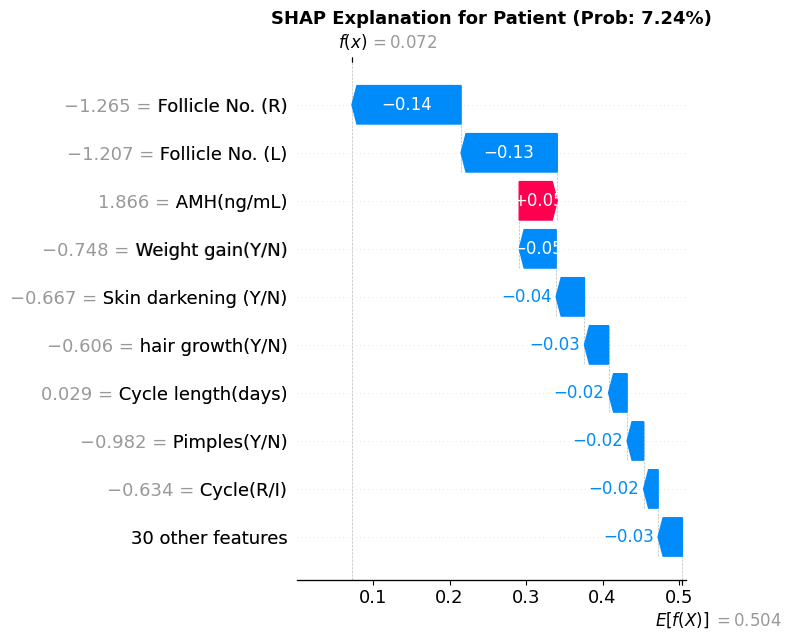

In [27]:
# Local SHAP Explanation - Single Patient
# Pick a sample patient (first PCOS positive in test set)
pcos_indices = y_test[y_test == 1].index.tolist()
sample_idx = 0  # First PCOS patient in test set
sample_patient = X_test_scaled.iloc[sample_idx:sample_idx+1]
sample_shap = shap_values_pcos[sample_idx]

print(f"Patient Index: {pcos_indices[sample_idx]}")
print(f"   Actual: {'PCOS' if y_test.iloc[sample_idx] == 1 else 'No PCOS'}")
print(f"   Predicted: {'PCOS' if y_pred[sample_idx] == 1 else 'No PCOS'}")
print(f"   Probability: {y_pred_proba[sample_idx]:.2%}")

# Waterfall plot for single prediction
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap.Explanation(
    values=sample_shap,
    base_values=explainer.expected_value[1],
    data=sample_patient.values[0],
    feature_names=X_test_scaled.columns.tolist()
), show=False)
plt.title(f"SHAP Explanation for Patient (Prob: {y_pred_proba[sample_idx]:.2%})", 
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
# Enhanced Narrative Generator with Recommendations
def generate_enhanced_narrative(shap_values, feature_names, feature_values, 
                                  prediction_prob, is_stage2=True, top_n=5):
    # Determine risk level
    if prediction_prob > 0.7:
        risk_level = "HIGH"
        risk_emoji = "🔴"
        confidence = "Strong"
    elif prediction_prob > 0.3:
        risk_level = "MODERATE"
        risk_emoji = "🟡"
        confidence = "Moderate"
    else:
        risk_level = "LOW"
        risk_emoji = "🟢"
        confidence = "Strong"
    
    # Normal ranges for context
    normal_ranges = {
        'Follicle No. (L)': '<12 follicles',
        'Follicle No. (R)': '<12 follicles',
        'BMI': '18.5-24.9',
        'AMH(ng/mL)': '1.0-4.0 ng/mL',
        'LH(mIU/mL)': '2-15 mIU/mL',
        'FSH(mIU/mL)': '3-10 mIU/mL',
        'Cycle length(days)': '21-35 days',
    }
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values,
        'actual_value': feature_values
    })
    importance_df['abs_shap'] = np.abs(importance_df['shap_value'])
    importance_df = importance_df.sort_values('abs_shap', ascending=False)
    
    # Separate increasing and decreasing factors
    increasing = importance_df[importance_df['shap_value'] > 0].head(top_n)
    decreasing = importance_df[importance_df['shap_value'] < 0].head(3)
    
    # Build narrative
    lines = []
    lines.append("=" * 60)
    lines.append("              PCOS RISK ASSESSMENT REPORT")
    lines.append("=" * 60)
    lines.append("")
    lines.append(f"{risk_emoji} RISK LEVEL: {risk_level}")
    lines.append(f"   Probability of PCOS: {prediction_prob:.1%}")
    lines.append(f"   Confidence: {confidence}")
    lines.append(f"   Assessment Type: {'Full Clinical (Stage 2)' if is_stage2 else 'Preliminary (Stage 1)'}")
    
    # Key factors increasing risk
    lines.append("")
    lines.append("-" * 60)
    lines.append("KEY FACTORS INCREASING RISK:")
    lines.append("-" * 60)
    
    for idx, (_, row) in enumerate(increasing.iterrows(), 1):
        feat = row['feature']
        val = row['actual_value']
        
        # Format value
        if val in [0, 1]:
            val_str = "Yes" if val == 1 else "No"
        else:
            val_str = f"{val:.2f}"
        
        # Add normal range if available
        normal = normal_ranges.get(feat, '')
        normal_str = f" (Normal: {normal})" if normal else ""
        
        lines.append(f"   {idx}. {feat}: {val_str}{normal_str}")
        lines.append(f"      → Impact: +{row['shap_value']:.3f}")
    
    # Protective factors
    if len(decreasing) > 0:
        lines.append("")
        lines.append("PROTECTIVE FACTORS:")
        for _, row in decreasing.iterrows():
            feat = row['feature']
            val = row['actual_value']
            val_str = "Yes" if val == 1 else "No" if val == 0 else f"{val:.2f}"
            lines.append(f"   • {feat}: {val_str} → Reduces risk")
    
    # Recommendations based on risk level
    lines.append("")
    lines.append("-" * 60)
    lines.append("CLINICAL RECOMMENDATIONS:")
    lines.append("-" * 60)
    
    if risk_level == "HIGH":
        if not is_stage2:
            lines.append("   ✓ URGENT: Refer for confirmatory ultrasound")
            lines.append("   ✓ Order hormonal panel (FSH, LH, AMH)")
        lines.append("   ✓ Evaluate for insulin resistance (HOMA-IR)")
        lines.append("   ✓ Screen for metabolic syndrome")
        lines.append("   ✓ Consider referral to endocrinologist")
        lines.append("   ✓ Discuss fertility planning if applicable")
    elif risk_level == "MODERATE":
        if not is_stage2:
            lines.append("   ✓ Consider ultrasound examination")
            lines.append("   ✓ Consider hormonal panel")
        lines.append("   ✓ Monitor symptoms for 3-6 months")
        lines.append("   ✓ Lifestyle modifications (diet, exercise)")
        lines.append("   ✓ Follow-up appointment recommended")
    else:  # LOW
        lines.append("   ✓ No immediate PCOS concerns")
        lines.append("   ✓ Continue regular health monitoring")
        lines.append("   ✓ Return if new symptoms develop")
    
    # Disclaimer
    lines.append("")
    lines.append("-" * 60)
    lines.append("DISCLAIMER:")
    lines.append("-" * 60)
    lines.append("   This is a decision support tool only. Final diagnosis")
    lines.append("   must be made by a qualified healthcare provider using")
    lines.append("   Rotterdam criteria and clinical judgment.")
    lines.append("=" * 60)
    
    return "\n".join(lines)

# Test the enhanced narrative
enhanced_narrative = generate_enhanced_narrative(
    shap_values=sample_shap,
    feature_names=X_test_scaled.columns.tolist(),
    feature_values=X_test.iloc[sample_idx].values,
    prediction_prob=y_pred_proba[sample_idx],
    is_stage2=True
)

print(enhanced_narrative)

              PCOS RISK ASSESSMENT REPORT

🟢 RISK LEVEL: LOW
   Probability of PCOS: 7.2%
   Confidence: Strong
   Assessment Type: Full Clinical (Stage 2)

------------------------------------------------------------
KEY FACTORS INCREASING RISK:
------------------------------------------------------------
   1. AMH(ng/mL): 16.90 (Normal: 1.0-4.0 ng/mL)
      → Impact: +0.050
   2. Fast food (Y/N): Yes
      → Impact: +0.017
   3. Pulse rate(bpm): 82.00
      → Impact: +0.009
   4. Age (yrs): 27.00
      → Impact: +0.005
   5. Reg.Exercise(Y/N): Yes
      → Impact: +0.004

PROTECTIVE FACTORS:
   • Follicle No. (R): Yes → Reduces risk
   • Follicle No. (L): Yes → Reduces risk
   • Weight gain(Y/N): No → Reduces risk

------------------------------------------------------------
CLINICAL RECOMMENDATIONS:
------------------------------------------------------------
   ✓ No immediate PCOS concerns
   ✓ Continue regular health monitoring
   ✓ Return if new symptoms develop

-----------------

In [30]:
# Simple Bar Chart Data for Web API
def get_shap_chart_data(shap_values, feature_names, feature_values, top_n=10):
    
    # Create DataFrame
    df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values,
        'actual_value': feature_values,
        'abs_shap': np.abs(shap_values)
    })
    
    # Sort by absolute impact and get top N
    df = df.sort_values('abs_shap', ascending=False).head(top_n)
    
    # Prepare chart data
    chart_data = []
    for _, row in df.iterrows():
        chart_data.append({
            'feature': row['feature'],
            'impact': round(row['shap_value'], 4),
            'direction': 'increases' if row['shap_value'] > 0 else 'decreases',
            'value': float(row['actual_value']) if not pd.isna(row['actual_value']) else None,
            'color': '#fb6f92' if row['shap_value'] > 0 else '#38b000'  # Pink/Green
        })
    
    return chart_data

# Test the chart data function
chart_data = get_shap_chart_data(
    shap_values=sample_shap,
    feature_names=X_test_scaled.columns.tolist(),
    feature_values=X_test.iloc[sample_idx].values,
    top_n=8
)

print("SHAP Chart Data for Web API:\n")
for item in chart_data:
    direction = "↑" if item['direction'] == 'increases' else "↓"
    print(f"   {direction} {item['feature']}: {item['impact']:+.4f}")

SHAP Chart Data for Web API:

   ↓ Follicle No. (R): -0.1426
   ↓ Follicle No. (L): -0.1257
   ↑ AMH(ng/mL): +0.0497
   ↓ Weight gain(Y/N): -0.0483
   ↓ Skin darkening (Y/N): -0.0370
   ↓ hair growth(Y/N): -0.0315
   ↓ Cycle length(days): -0.0242
   ↓ Pimples(Y/N): -0.0216


In [31]:
# Save Model, Scaler, and Configuration
import joblib
import json

# Create models directory path
models_dir = "../models/"

# 1. Save the trained model
model_path = models_dir + "pcos_random_forest.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved: {model_path}")

# 2. Save the scaler
scaler_path = models_dir + "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# 3. Calculate and save training means (for Stage 1 imputation)
training_means = X_train.mean().to_dict()
means_path = models_dir + "training_means.json"
with open(means_path, 'w') as f:
    json.dump(training_means, f, indent=2)
print(f"Training means saved: {means_path}")

# 4. Save SHAP explainer expected value
explainer_config = {
    'expected_value_class0': float(explainer.expected_value[0]),
    'expected_value_class1': float(explainer.expected_value[1]),
}
explainer_path = models_dir + "explainer_config.json"
with open(explainer_path, 'w') as f:
    json.dump(explainer_config, f, indent=2)
print(f"Explainer config saved: {explainer_path}")

# 5. Save complete model info
model_info = {
    'model_type': 'RandomForestClassifier',
    'accuracy': float(test_accuracy),
    'f1_score': float(test_f1),
    'roc_auc': float(test_roc_auc),
    'precision': float(test_precision),
    'recall': float(test_recall),
    'n_features': len(ALL_FEATURES),
    'stage1_features': STAGE1_FEATURES,
    'stage2_features': STAGE2_FEATURES,
    'target': TARGET,
    'training_samples': len(X_train_resampled),
    'test_samples': len(X_test),
}
info_path = models_dir + "model_info.json"
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved: {info_path}")

print("\n" + "="*50)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*50)

Model saved: ../models/pcos_random_forest.pkl
Scaler saved: ../models/scaler.pkl
Training means saved: ../models/training_means.json
Explainer config saved: ../models/explainer_config.json
Model info saved: ../models/model_info.json

ALL ARTIFACTS SAVED SUCCESSFULLY!


In [33]:
# Model Development Summary
print("="*60)
print("        MODEL DEVELOPMENT COMPLETE")
print("="*60)

print("\nMODEL PERFORMANCE:")
print(f"   • Accuracy:  {test_accuracy:.2%}")
print(f"   • Precision: {test_precision:.2%}")
print(f"   • Recall:    {test_recall:.2%}")
print(f"   • F1 Score:  {test_f1:.2%}")
print(f"   • ROC-AUC:   {test_roc_auc:.2%}")

print("\nTARGET MET: Accuracy > 85%")

print("\nSAVED ARTIFACTS:")
print("   • ml/models/pcos_random_forest.pkl")
print("   • ml/models/scaler.pkl")
print("   • ml/models/training_means.json")
print("   • ml/models/explainer_config.json")
print("   • ml/models/model_info.json")

print("\nKEY FUNCTIONS CREATED:")
print("   • generate_enhanced_narrative() - For PDF reports")
print("   • get_shap_chart_data() - For web API")

print("="*60)

        MODEL DEVELOPMENT COMPLETE

MODEL PERFORMANCE:
   • Accuracy:  92.66%
   • Precision: 93.75%
   • Recall:    83.33%
   • F1 Score:  88.24%
   • ROC-AUC:   93.78%

TARGET MET: Accuracy > 85%

SAVED ARTIFACTS:
   • ml/models/pcos_random_forest.pkl
   • ml/models/scaler.pkl
   • ml/models/training_means.json
   • ml/models/explainer_config.json
   • ml/models/model_info.json

KEY FUNCTIONS CREATED:
   • generate_enhanced_narrative() - For PDF reports
   • get_shap_chart_data() - For web API
